# Importing Packages

In [2]:
import numpy as np
import pandas as pd
import gc
import random
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.nn as nn
import torch
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Model
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(10)
random.seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading Data

In [3]:
usd_cad = pd.read_csv('.../USDCAD_H4.csv', header=None)
usd_cad.columns = ['time',	'open',	'high',	'low',	'close',	'volume']
gbp_usd = pd.read_csv('.../GBPUSD_H4.csv', header=None)
gbp_usd.columns = ['time',	'open',	'high',	'low',	'close',	'volume']
eur_usd = pd.read_csv('.../EURUSD_H4.csv', header=None)
eur_usd.columns = ['time',	'open',	'high',	'low',	'close',	'volume']
usd_jpy = pd.read_csv('.../USDJPY_H4.csv', header=None)
usd_jpy.columns = ['time',	'open',	'high',	'low',	'close',	'volume']
usd_chf = pd.read_csv('.../USDCHF_H4.csv', header=None)
usd_chf.columns = ['time',	'open',	'high',	'low',	'close',	'volume']
usd_cad.head()

,time,open,high,low,close,volume
0,2008-02-19 08:00,1.00540,1.00550,1.00350,1.00385,7110
1,2008-02-19 12:00,1.00385,1.01230,1.00180,1.01205,62121
2,2008-02-19 16:00,1.01205,1.01715,1.01140,1.01685,48258
3,2008-02-19 20:00,1.01680,1.01760,1.01535,1.01550,58842
4,2008-02-20 00:00,1.01550,1.01690,1.01460,1.01510,34881


# Ploting Candles

In [117]:
np.random.seed(10)
candle_plot_start = np.random.randint(0, 25847-30)
fig = go.Figure(data=[go.Candlestick(x=usd_cad.iloc[candle_plot_start+19:candle_plot_start+30]['time'],
                open=usd_cad.iloc[candle_plot_start+19:candle_plot_start+30]['open'],
                high=usd_cad.iloc[candle_plot_start+19:candle_plot_start+30]['high'],
                low=usd_cad.iloc[candle_plot_start+19:candle_plot_start+30]['low'],
                close=usd_cad.iloc[candle_plot_start+19:candle_plot_start+30]['close'])])

fig.show()

# Utils

In [ ]:
def create_id_data(row):
  '''
  This function add required features to make data compatible with Word-based Model
  Args:
      row : each row of DataFrame
  Returns:
      color : indicates candle color
      shadow_up : indicates candle upper shadow
      shadow_up : indicates candle lower shadow
      shape : indicates candle shape
  '''

  open, high, low, close = row[['open', 'high', 'low', 'close']]
  shape = close - open
  if shape < 0:
    shape = abs(shape)
    row['color'] = -1
    s_up = high - open
    s_down = close - low
    row['shadow_up'] = s_up
    row['shadow_down'] = s_down
  else:
    row['color'] = 1
    s_up = high - close
    s_down = open - low
    row['shadow_up'] = s_up
    row['shadow_down'] = s_down

  row['shape'] = shape
  return row

def visualize_dist(df, col_bin, has_bin=False):
  '''
  This function visualize distribution of (shadow_up, shadow_down, shape, volume) for whole data
  Args:
      df (datafram): Whole data
      col_bin (list): Given columns and number of their bins for plot
      has_bin (boolean): Data already has quantiles
  '''

  f, axs = plt.subplots(2, 2)
  f.set_figheight(8)
  f.set_figwidth(10)
  if not has_bin:
    for i, ax in enumerate([ax for axis in axs for ax in axis]):
      sns.kdeplot(df, x=col_bin[i][0], ax=ax)
  else:
    for i, ax in enumerate([ax for axis in axs for ax in axis]):
      sns.histplot(data=df, x=col_bin[i], ax=ax, color='b')
  plt.show()

def reconstruct_candle(close_prev, candle, scalers, ix):
  '''
  This function reconstruct candle from Word
  Args:
      close_prev (float): Previous candle close value
      candle (list): A candle respect to color, shadow_up, shadow_down, shape
      scalers (list): List of scalers for inverse transform
      ix (int): Index of scaler
  Returns:
      candle (list): open, high, low, close
  '''

  for k, vals in scalers.items():
    for v in vals:
      if v[0] < ix < v[1]:
        if k == 'shadow_up':
          shadow_up = v[2].inverse_transform(np.asarray(candle[1]).reshape(-1, 1))[0, 0]
        elif k == 'shadow_down':
          shadow_down = v[2].inverse_transform(np.asarray(candle[2]).reshape(-1, 1))[0, 0]
        else:
          shape = v[2].inverse_transform(np.asarray(candle[3]).reshape(-1, 1))[0, 0]
  open = close_prev
  if candle[0] == 1:
    close = open + shape
    low = open - shadow_down
    high = close + shadow_up
  else:
    close = open - shape
    low = close - shadow_down
    high = open + shadow_up
  return [open, high, low, close]

def scaling(x, train_index, cat_index, scalers):
  '''
  This function performs StandardScaler respect to each market
  Args:
      x (series): The column to scale
      train_index (list[int]): Train data indices to fit scaler
      cat_index (list[int]): Indices of where each market
      scalers (list[dict]): List of scalers for future invers transform
  Returns:
      data (series): Scaled data respect to x
  '''

  x_train = x.iloc[train_index]
  data = []
  inverse_data = []
  for i in range(5):
    scaler = StandardScaler(with_std=False)
    scaler.fit(x_train.iloc[cat_index[i]:cat_index[i+1]].to_numpy().reshape(-1, 1))
    curr_x = scaler.transform(x.iloc[cat_index[i]:cat_index[i+1]].to_numpy().reshape(-1, 1))
    data = np.append(data, curr_x.reshape(1, -1)[0])
    inverse_data.append((cat_index[i], cat_index[i+1], scaler))
    past = i
  scalers[x.name] = inverse_data
  return data

def inverse_sclaing(x, scalers):
  '''
  This function performs inverse transform
  Args:
      x (series): The column to inverse scaled data
      scalers (list[dict]): List of scalers
  Returns:
      data (series): Reversed scaled data respect to x
  '''

  scalers = scalers[x.name]
  data = []
  for s in scalers:
    start = s[0]
    end = s[1]
    scaler = s[2]
    data = np.append(data, scaler.inverse_transform(x[start:end].to_numpy().reshape(-1, 1)).reshape(1, -1)[0])
  return data

def discretization(x, bins=10):
  '''
  This function performs a complex operation
  Args:
      x (series): The column to quantile
      bins (int): The number of bins
  Returns:
      The mid of each quantile
  '''

  try:
    quantiles = pd.qcut(x, bins)
  except:
    quantiles = pd.qcut(x, bins+1)
  return quantiles.apply(lambda x: x.mid).astype(float)

# Preprocessing

## Add extra features for Word Model

Here we select Word-based Model or Embedding-based Model by choosing `input_type`

In [6]:
# Word-based Model
input_type = 'input_ids'
# Embedding-based Model
# input_type = 'inputs_embeds'

if input_type == 'input_ids':
  usd_cad = usd_cad.apply(create_id_data, axis=1)
  gbp_usd = gbp_usd.apply(create_id_data, axis=1)
  eur_usd = eur_usd.apply(create_id_data, axis=1)
  usd_jpy = usd_jpy.apply(create_id_data, axis=1)
  usd_chf = usd_chf.apply(create_id_data, axis=1)
  display(usd_cad.head())

,time,open,high,low,close,volume,color,shadow_up,shadow_down,shape
0,2008-02-19 08:00,1.00540,1.00550,1.00350,1.00385,7110,-1,0.00010,0.00035,0.00155
1,2008-02-19 12:00,1.00385,1.01230,1.00180,1.01205,62121,1,0.00025,0.00205,0.00820
2,2008-02-19 16:00,1.01205,1.01715,1.01140,1.01685,48258,1,0.00030,0.00065,0.00480
3,2008-02-19 20:00,1.01680,1.01760,1.01535,1.01550,58842,-1,0.00080,0.00015,0.00130
4,2008-02-20 00:00,1.01550,1.01690,1.01460,1.01510,34881,-1,0.00140,0.00050,0.00040


## Scaling and Discretization

In [8]:
whole_data = [usd_cad, gbp_usd, eur_usd, usd_jpy, usd_chf]
vocab = pd.concat(whole_data)
cat_period = [0]
for df_ in whole_data:
  cat_period.append(cat_period[-1] + df_.shape[0])
vocab = vocab.reset_index(drop=True)
window_size = 10
test_index = []
for i, j in zip([0] + cat_period, cat_period + [vocab.shape[0]]):
  for k in range(i, j, window_size):
    if i == k:
      continue
    test_index.append(k)
train_index = np.setdiff1d(vocab.index, test_index, assume_unique=True)
scalers = {}
if input_type == 'input_ids':
  vocab[['shadow_up', 'shadow_down', 'shape']] = vocab[['shadow_up', 'shadow_down', 'shape']].apply(scaling, train_index=train_index, cat_index=cat_period, scalers=scalers)
  vocab[['shadow_up', 'shadow_down', 'shape']] = vocab[['shadow_up', 'shadow_down', 'shape']].apply(discretization, bins=15)
  vocab['id'] = vocab.groupby(['color', 'shadow_up', 'shadow_down', 'shape']).ngroup()
vocab.head()

,time,open,high,low,close,volume,color,shadow_up,shadow_down,shape,id
0,2008-02-19 08:00,1.00540,1.00550,1.00350,1.00385,7110,-1,-0.000872,-0.000690,-0.000367,430
1,2008-02-19 12:00,1.00385,1.01230,1.00180,1.01205,62121,1,-0.000872,0.001520,0.038525,2017
2,2008-02-19 16:00,1.01205,1.01715,1.01140,1.01685,48258,1,-0.000872,-0.000353,0.002740,1975
3,2008-02-19 20:00,1.01680,1.01760,1.01535,1.01550,58842,-1,-0.000325,-0.000885,-0.000740,727
4,2008-02-20 00:00,1.01550,1.01690,1.01460,1.01510,34881,-1,0.000574,-0.000527,-0.001745,1070


# Plotting Features Distribution before and after Quantile

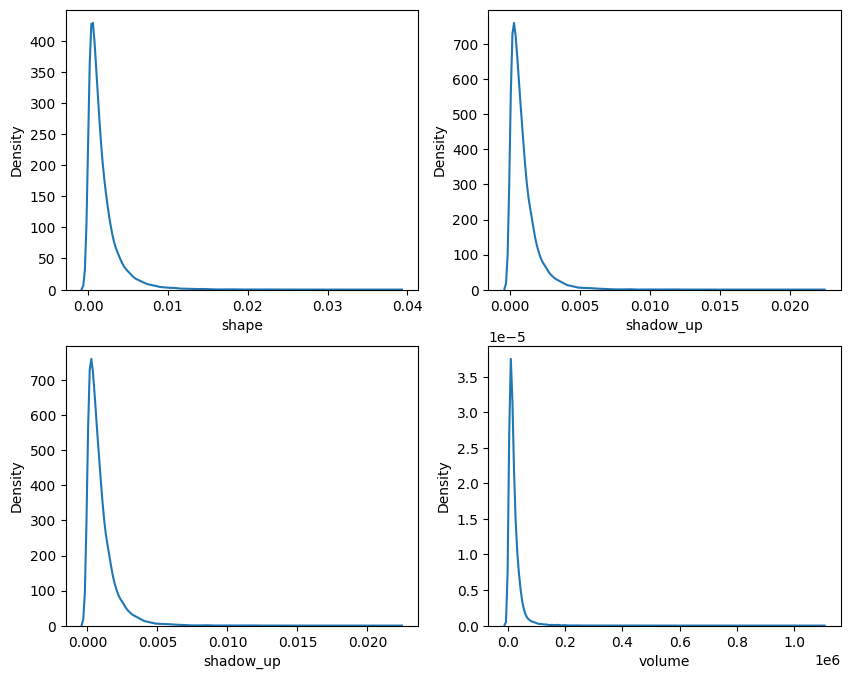

In [7]:
if input_type == 'input_ids':
  visualize_dist(usd_cad, [('shape', 15), ('shadow_up', 15), ('shadow_up', 15), ('volume', 5)])

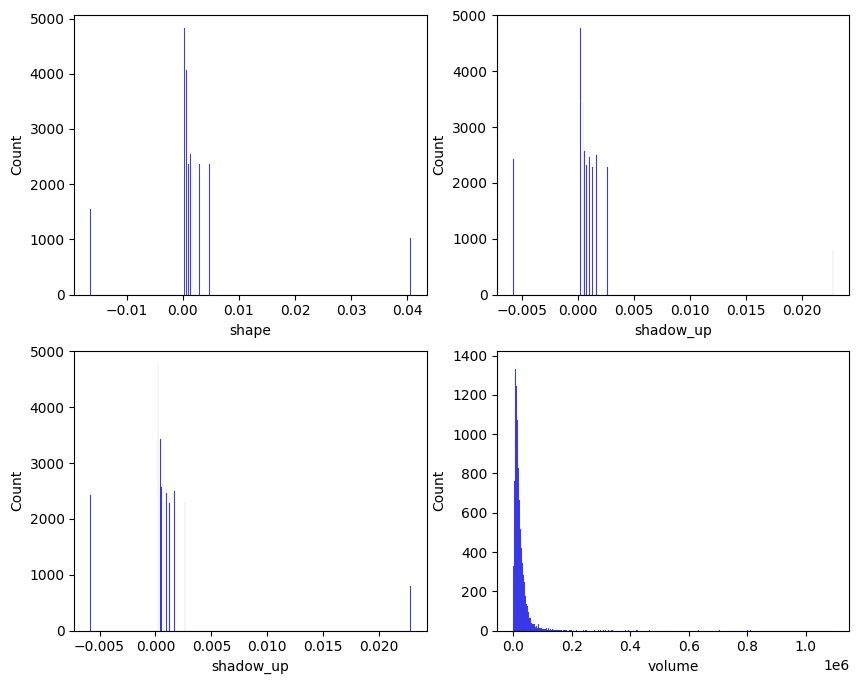

In [10]:
if input_type == 'input_ids':
  usd_cad_bin = vocab[['shadow_up', 'shadow_down', 'shape']].apply(inverse_sclaing, scalers=scalers).iloc[:cat_period[1]]
  usd_cad_bin['volume'] = vocab['volume'].iloc[:cat_period[1]]
  visualize_dist(usd_cad_bin, ['shape', 'shadow_up', 'shadow_up', 'volume'], has_bin=True)

## Plotting Candles respect to Loss after Quantiles

In [20]:
# Here we reconstruct a Candlestick from it's color, shadow_up, shadow_down, shape
# Then we compare the reconstructed candle with it's original open, high, low, close
if input_type == 'input_ids':
  candle_recons = reconstruct_candle(1.01205, [1, -0.000872, -0.000353, 0.002740], scalers, 2)
  candle_true = vocab[['time', 'open', 'high', 'low', 'close']].iloc[2].to_numpy()
  temp_df = pd.DataFrame(
      {
          'time': [candle_true[0], '2008-02-19 20:00'],
          'open': [candle_true[1], candle_recons[0]],
          'high': [candle_true[2], candle_recons[1]],
          'low': [candle_true[3], candle_recons[2]],
          'close': [candle_true[4], candle_recons[3]]
      }
  )
  print(candle_recons)
  print(abs(np.asarray(candle_recons) - vocab[['open', 'high', 'low', 'close']].iloc[2].to_numpy()))
  fig = go.Figure(data=[go.Candlestick(x=temp_df['time'],
                  open=temp_df['open'],
                  high=temp_df['high'],
                  low=temp_df['low'],
                  close=temp_df['close'])])

  fig.show()

# Creating Train, Test, Validation Datasets

In [37]:
# We're going to consider each candlestick as a token, Therefore each sentence will be a window of candles.
data = {'x':[], 'y':[]}
if input_type == 'input_ids':
  for i in test_index:
    data['x'].append(vocab.iloc[i-window_size:i]['id'].to_numpy())
    data['y'].append(np.asarray(vocab.id[i]))
  data = pd.DataFrame(data)
else:
  for i in test_index:
    data['x'].append(vocab.iloc[i-window_size:i][['open', 'high', 'low', 'close']].to_numpy(dtype=np.float32))
    data['y'].append(vocab.iloc[i][['open', 'high', 'low', 'close']].to_numpy(dtype=np.float32))
  data = pd.DataFrame(data)
data.head()

,x,y
0,"[430, 2017, 1975, 727, 1070, 2636, 605, 2155, ...",835
1,"[835, 2329, 1891, 480, 378, 2078, 825, 2059, 6...",2612
2,"[2612, 342, 525, 466, 636, 601, 632, 886, 450,...",2280
3,"[2280, 492, 301, 792, 2480, 564, 342, 2125, 34...",2219
4,"[2219, 745, 769, 1083, 1210, 2119, 2479, 2489,...",1252


In [38]:
X_train, X_test, y_train, y_test = train_test_split(data.x, data.y, test_size=0.2, random_state=42)
train_data = pd.concat((X_train, y_train), axis=1)
X_train, X_val, y_train, y_val = train_test_split(train_data.x, train_data.y, test_size=0.1, random_state=42)

In [39]:
class ChartDataset(Dataset):
  '''
  Dataset to present Chart

  '''

  def __init__(self, x, y, input_type):
    self.x = x
    self.y = y
    self.input_type = input_type

  def __getitem__(self, idx):
    '''
    Based on input_type, either input_ids for Word Model or inputs_embeds for Embedding Model, input for model is created.
    Also labels are same as input but shifted one to left.

    '''
    input = {self.input_type: torch.tensor(self.x[idx], device=device), 'position_ids': torch.arange(self.x[idx].shape[0], device=device)}
    labels = torch.tensor(self.x[idx], device=device).roll(-1, dims=0)
    labels[-1] = torch.from_numpy(self.y[idx])
    return input, labels

  def __len__(self):
    return len(self.y)

train_dataset = ChartDataset(X_train.to_numpy(), y_train.to_numpy(), input_type)
val_dataset = ChartDataset(X_val.to_numpy(), y_val.to_numpy(), input_type)
test_dataset = ChartDataset(X_test.to_numpy(), y_test.to_numpy(), input_type)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Implementing Embedding-based Model

In [ ]:
class CustomGPT(nn.Module):
  '''
  This Model has same architecture as GPT-2 from Huggingface.
  However here we use two (encoder, decoder) layers to create token embeddings (768 dimension).

  '''
  def __init__(self, gpt_model, window_size):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(4, 256),
        nn.BatchNorm1d(window_size, eps=1e-08),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(window_size, eps=1e-08),
        nn.ReLU(),
        nn.Linear(512, 768)
    )
    self.gpt = gpt_model
    self.encoder = nn.Sequential(
        nn.Linear(768, 256),
        nn.BatchNorm1d(window_size, eps=1e-08),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(window_size, eps=1e-08),
        nn.ReLU(),
        nn.Linear(128, 4)
    )

  def forward(self, inputs_embeds):
    x = self.decoder(inputs_embeds)
    x = self.gpt(inputs_embeds=x).last_hidden_state
    x = self.encoder(x)
    return x

# Tran and Test Functions

In [25]:
def train_one_epoch(model, dataloader, optimizer, input_type, criterion=nn.MSELoss()):
  model.train()
  accu_loss = 0
  for x, y in dataloader:
    optimizer.zero_grad()
    if input_type == 'input_ids':
      loss = model(input_ids=x[input_type], labels=y).loss
    else:
      y_pred = model(x[input_type])
      loss = criterion(y_pred, y)
    accu_loss += loss.item()
    loss.backward()
    optimizer.step()
  overall_loss = accu_loss / len(dataloader)
  return overall_loss

def test_one_epoch(model, dataloader, input_type, criterion=nn.MSELoss()):
  model.eval()
  with torch.no_grad():
    accu_loss = 0
    for x, y in dataloader:
      if input_type == 'input_ids':
        loss = model(input_ids=x[input_type], labels=y).loss
      else:
        y_pred = model(x[input_type])
        loss = criterion(y_pred, y)
      accu_loss += loss.item()
    overall_loss = accu_loss / len(dataloader)
  return overall_loss

# Creating Model based on input type (Word-based or Embedding-based)

In [26]:
if input_type == 'input_ids':
  # Downloding both pretrained GPT model, and custom configuration GPT for our vocab size.
  configuration = GPT2Config(vocab_size=vocab.id.unique().size)
  gpt = GPT2LMHeadModel(configuration)
  gpt_pretrained = GPT2LMHeadModel.from_pretrained('gpt2')
else:
  # Removing wte layer from Embedding-based Model
  gpt_pretrained_emb = GPT2Model.from_pretrained('gpt2')
  del gpt_pretrained_emb.wte

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [27]:
# Here we copy all weights (compatible ones) from pretrained to Word-based Model
if input_type == 'input_ids':
  state = gpt_pretrained.state_dict()
  del state['transformer.wte.weight']
  del state['transformer.wpe.weight']
  del state['lm_head.weight']
  gpt.load_state_dict(state, strict=False)

In [28]:
# Freezing all model parameters
if input_type == 'input_ids':
  for i, j in zip(gpt.parameters(), gpt_pretrained.parameters()):
    if i.shape != j.shape:
      continue
    i.requires_grad = False
else:
  for param in gpt_pretrained_emb.parameters():
    param.requires_grad = False

In [29]:
# Defining learning rate, optimizer and number of epochs
if input_type == 'input_ids':
  model = gpt
  epoch = 20
else:
  model = CustomGPT(gpt_pretrained_emb, window_size)
  epoch = 30
model.to(device)
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

# Words Model

## Training and Fine-tuning

In [40]:
train_losses = []
val_losses = []
for i in range(epoch):
  gc.collect()
  train_loss = train_one_epoch(model, train_dataloader, optimizer, input_type)
  val_loss = test_one_epoch(model, val_dataloader, input_type)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f'Epoch {i+1}: Train Loss = {train_loss:0.4}, Val Loss = {val_loss:0.4}')

Epoch 1: Train Loss = 8.652, Val Loss = 7.957
Epoch 2: Train Loss = 7.742, Val Loss = 7.684
Epoch 3: Train Loss = 7.493, Val Loss = 7.481
Epoch 4: Train Loss = 7.34, Val Loss = 7.401
Epoch 5: Train Loss = 7.233, Val Loss = 7.312
Epoch 6: Train Loss = 7.162, Val Loss = 7.281
Epoch 7: Train Loss = 7.1, Val Loss = 7.18
Epoch 8: Train Loss = 7.023, Val Loss = 7.176
Epoch 9: Train Loss = 6.969, Val Loss = 7.127
Epoch 10: Train Loss = 6.914, Val Loss = 7.098
Epoch 11: Train Loss = 6.853, Val Loss = 7.075
Epoch 12: Train Loss = 6.815, Val Loss = 7.016
Epoch 13: Train Loss = 6.777, Val Loss = 6.985
Epoch 14: Train Loss = 6.743, Val Loss = 6.974
Epoch 15: Train Loss = 6.716, Val Loss = 7.011
Epoch 16: Train Loss = 6.684, Val Loss = 6.96
Epoch 17: Train Loss = 6.666, Val Loss = 6.946
Epoch 18: Train Loss = 6.639, Val Loss = 6.929
Epoch 19: Train Loss = 6.617, Val Loss = 6.944
Epoch 20: Train Loss = 6.601, Val Loss = 6.945
Epoch 21: Train Loss = 6.585, Val Loss = 6.946
Epoch 22: Train Loss = 6.56

In [41]:
for param in model.parameters():
  param.requires_grad = True

lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
epoch = 8
best_loss = 1e+09
best_params = None
for i in range(epoch):
  gc.collect()
  train_loss = train_one_epoch(model, train_dataloader, optimizer, input_type)
  val_loss = test_one_epoch(model, val_dataloader, input_type)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_loss < best_loss:
    best_loss = val_loss
    best_params = deepcopy(model.state_dict())
  print(f'Epoch {i+1}: Train Loss = {train_loss:0.4}, Val Loss = {val_loss:0.4}')

Epoch 1: Train Loss = 6.258, Val Loss = 6.76
Epoch 2: Train Loss = 6.116, Val Loss = 6.813
Epoch 3: Train Loss = 6.001, Val Loss = 6.875
Epoch 4: Train Loss = 5.892, Val Loss = 6.951
Epoch 5: Train Loss = 5.772, Val Loss = 7.046


In [ ]:
test_one_epoch(model, test_dataloader, input_type)

## Plotting Train loss vs Validation loss

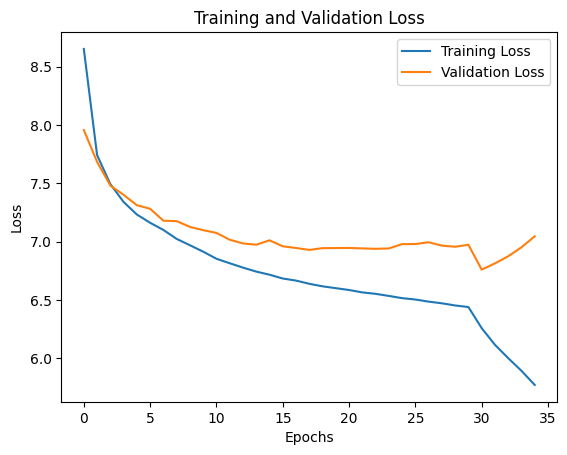

In [43]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

## Generating next token (Candlestick) using trained model

In [115]:
period = vocab.iloc[candle_plot_start+29-window_size:candle_plot_start+29]
input_tensor = torch.tensor(period['id'].to_numpy(), device=device)
pred_candle = model(input_ids=input_tensor)['logits'][-1:].argmax().item()
pred_candle = vocab[vocab.id == pred_candle][['color', 'shadow_up', 'shadow_down', 'shape']].drop_duplicates().values.tolist()[0]
recons_candle = reconstruct_candle(period.close.iloc[-1], pred_candle, scalers, 10)
temp = pd.concat([period[['time', 'open', 'high', 'low', 'close']],
           pd.DataFrame({
               'time': ['2019-02-08 12:00'],
               'open': [recons_candle[0]],
               'high': [recons_candle[1]],
               'low': [recons_candle[2]],
               'close': [recons_candle[3]]
           })])
fig = go.Figure(data=[go.Candlestick(x=temp['time'],
                open=temp['open'],
                high=temp['high'],
                low=temp['low'],
                close=temp['close'])])
fig.show()

# Embeddings Model

## Training and Fine-tuning

In [33]:
train_losses = []
val_losses = []
for i in range(epoch):
  gc.collect()
  train_loss = train_one_epoch(model, train_dataloader, optimizer, input_type)
  val_loss = test_one_epoch(model, val_dataloader, input_type)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f'Epoch {i+1}: Train Loss = {train_loss:0.4}, Val Loss = {val_loss:0.4}')

Epoch 1: Train Loss = 1.518e+03, Val Loss = 858.8
Epoch 2: Train Loss = 487.2, Val Loss = 209.0
Epoch 3: Train Loss = 78.03, Val Loss = 19.94
Epoch 4: Train Loss = 53.22, Val Loss = 22.5
Epoch 5: Train Loss = 31.09, Val Loss = 1.593
Epoch 6: Train Loss = 33.42, Val Loss = 17.88
Epoch 7: Train Loss = 15.37, Val Loss = 0.4755
Epoch 8: Train Loss = 14.9, Val Loss = 0.5108
Epoch 9: Train Loss = 9.939, Val Loss = 2.646
Epoch 10: Train Loss = 10.81, Val Loss = 0.5277
Epoch 11: Train Loss = 10.66, Val Loss = 10.15
Epoch 12: Train Loss = 16.26, Val Loss = 151.4
Epoch 13: Train Loss = 11.3, Val Loss = 1.36
Epoch 14: Train Loss = 9.155, Val Loss = 4.146
Epoch 15: Train Loss = 13.68, Val Loss = 6.509
Epoch 16: Train Loss = 12.54, Val Loss = 17.46
Epoch 17: Train Loss = 13.5, Val Loss = 3.732
Epoch 18: Train Loss = 8.985, Val Loss = 3.833
Epoch 19: Train Loss = 11.33, Val Loss = 4.066
Epoch 20: Train Loss = 12.22, Val Loss = 0.4837
Epoch 21: Train Loss = 8.876, Val Loss = 5.584
Epoch 22: Train Los

In [34]:
for param in model.parameters():
  param.requires_grad = True

lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
epoch = 10
best_loss = 1e+09
best_params = None
for i in range(epoch):
  gc.collect()
  train_loss = train_one_epoch(model, train_dataloader, optimizer, input_type)
  val_loss = test_one_epoch(model, val_dataloader, input_type)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_loss < best_loss:
    best_loss = val_loss
    best_params = deepcopy(model.state_dict())
  print(f'Epoch {i+1}: Train Loss = {train_loss:0.4}, Val Loss = {val_loss:0.4}')

Epoch 1: Train Loss = 15.59, Val Loss = 6.973
Epoch 2: Train Loss = 12.09, Val Loss = 0.7763
Epoch 3: Train Loss = 9.364, Val Loss = 1.829
Epoch 4: Train Loss = 7.97, Val Loss = 0.4705
Epoch 5: Train Loss = 8.551, Val Loss = 1.158
Epoch 6: Train Loss = 6.174, Val Loss = 3.826
Epoch 7: Train Loss = 8.119, Val Loss = 0.8302
Epoch 8: Train Loss = 9.071, Val Loss = 3.237
Epoch 9: Train Loss = 7.39, Val Loss = 0.8925
Epoch 10: Train Loss = 6.351, Val Loss = 5.064


In [ ]:
test_one_epoch(model, test_dataloader, input_type)

## Plotting Train loss vs Test loss

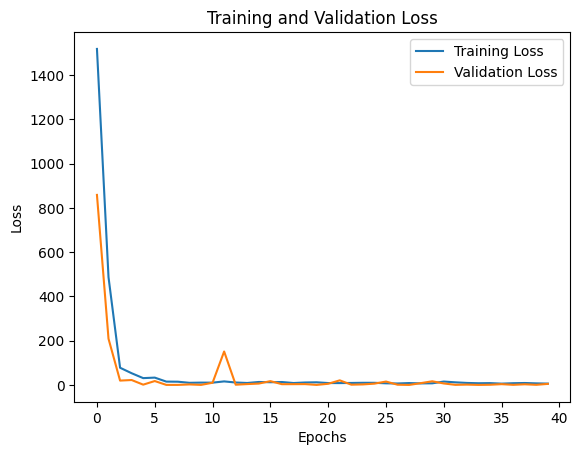

In [38]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

## Generating next token (Candlestick) using trained model

In [49]:
period = usd_cad.iloc[candle_plot_start+29-window_size:candle_plot_start+29]
input_tensor = torch.tensor(period[['open', 'high', 'low', 'close']].to_numpy(),
                            dtype=torch.float, device=device)
pred_candle = model(input_tensor.unsqueeze(0))[0][-1]
pred_candle = [usd_cad.iloc[candle_plot_start+29]['time']] + pred_candle.tolist()

temp = pd.concat((period[['time', 'open', 'high', 'low', 'close']],
                  pd.DataFrame([pred_candle], columns=['time', 'open', 'high', 'low', 'close'])))
fig = go.Figure(data=[go.Candlestick(x=temp['time'],
                open=temp['open'],
                high=temp['high'],
                low=temp['low'],
                close=temp['close'])])
fig.show()

# Saving Model

In [ ]:
if input_type == 'input_ids':
  torch.save(best_params, '/content/drive/MyDrive/CurrentData/wrod_model_params.pt')
else:
  torch.save(best_params, '/content/drive/MyDrive/CurrentData/embed_model_params.pt')